# Tutorial 8 - Recommender Systems Part II  

Last week, we looked at loading and exploring datasets with users' feedback and played with a range of recommendation techniques, such as non-personalized approaches and traditional collaborative filtering approaches. We also introduced simple evaluation settings for rating prediction tasks on top of the Surprise package. This tutorial explores an alternative technique for collaborative filtering using latent factor models, on both rating prediction and ranking prediction tasks, with simple TensorFlow recipes. Furthermore, this tutorial covers a range of train-test splits, the creation of recommended lists, and the computation of decision-support and rank-aware top-k metrics that are fundamental for the evaluation of recommender systems.   

**Expected Tasks**

- Follow the latent factor models showcase in TensorFlow.
- Solve a range of exercises throughout the notebook. 

**Learning Objectives**

- Load and explore dataset with users' feedback. 
- Implement a train-test split technique. 
- Create and train a latent factor model.
- Compute the recommended list of a given user. 
- Evaluate a recommender systems, using different metrics.

In [1]:
from sklearn.metrics import roc_auc_score
import scipy.sparse as sp
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import datetime
import time 
import math
import os

In [2]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


You are using pip version 18.1, however version 21.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
from tqdm import tqdm

## Step #1: Load the Movielens 1M data set
---

**Reference**: Harper, F. M., & Konstan, J. A. (2015). The Movielens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TIIS), 5(4), 1-19. [https://dl.acm.org/doi/10.1145/2827872](https://dl.acm.org/doi/10.1145/2827872). 

The MovieLens datasets, first released in 1998, describe people’s expressed preferences for movies. These preferences take the form of <user, item, rating, timestamp> tuples, each the result of a person expressing a preference (a 0–5 star rating) for a movie at a particular time. These preferences were entered by way of the MovieLens website, a recommender system that asks its users to give movie ratings in order to receive personalized movie recommendations. 

The MovieLens datasets are heavily downloaded and referenced in the research literature. This popularity is, to a certain degree, a reflection of the incredible rate of growth of personalization and recommendation research, in which datasets such as these have substantial value in exploring and validating ideas. The popularity might also be attributed to the flexibility of ratings data. Also, because movie preferences are highly subject to personal tastes, the movie domain is well suited to testing personalization technology. Finally, the popularity may reflect the perceived accessibility of movies as a content domain: movies are a common interest, making algorithmic output easy to discuss. 

In this tutorial, we will play with a small version of a dataset collected from the Movielens platform. Specifically, we will use the MovieLens 1M movie ratings dataset ([https://grouplens.org/datasets/movielens/1m/](https://grouplens.org/datasets/movielens/1m/)), with 1 million ratings from 6000 users on 4000 movies. The dataset includes information about **ratings**, **movies**, **users**. 

All **ratings** are contained in the file "ratings.dat" and are in the following format: user_id::item_id::rating::timestamp. 
- User IDs range between 1 and 6040. 
- Item IDs range between 1 and 3952.
- Ratings are made on a 5-star scale (whole-star ratings only). 
- Timestamp is represented in seconds since the epoch as returned by time. 
- Each user has at least 20 ratings. 

In [4]:
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'],engine='python')

In [5]:
ratings.sample(10)

,user_id,item_id,rating,timestamp
5744,42,2140,3,978040305
65638,438,1219,4,981602428
43588,300,3082,2,976507505
114562,744,2762,4,975472452
526501,3257,2918,5,968276069
946810,5717,1029,4,958744684
159102,1017,2420,4,975011604
45481,307,1256,5,976485814
504113,3099,3257,4,969593848
805749,4823,1902,2,1000086880


In [6]:
no_users, no_items, no_ratings = len(ratings.user_id.unique()), len(ratings.item_id.unique()), len(ratings.index)

In [7]:
no_users, no_items, no_ratings

(6040, 3706, 1000209)

Then, we load the movies. All movies information is in the file "movies.dat" and is in the following format: item_id::title::genres. 

- Titles are identical to titles provided by the IMDB (including year of release). 
- Genres are pipe-separated and are selected from the following genres (Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Wester). 
- Some MovieIDs do not correspond to a movie due to accidental duplicate entries and/or test entries. 
- Movies are mostly entered by hand, so errors and inconsistencies may exist. 

In [8]:
items = pd.read_csv('ml-1m/movies.dat', sep='::', names=['item_id', 'title', 'genres'], engine='python')

In [9]:
items.head()

,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


For convenience, we re-scale the user ids from $0$ to $|\text{no_users}-1|$ and the item ids from $0$ to $|\text{no_items}-1|$. This pre-processing step will allow us to use the id as an index in the latent factors matrices of users and items. For convenience, we also keep two columns with the original user ids and item ids. 

In [10]:
ratings['original_user_id'] = ratings['user_id']
ratings['original_item_id'] = ratings['item_id']
ratings['user_id'] = ratings['user_id'].astype('category').cat.codes
ratings['item_id'] = ratings['item_id'].astype('category').cat.codes

In [11]:
min(ratings['user_id']), max(ratings['user_id']), min(ratings['item_id']), max(ratings['item_id'])

(0, 6039, 0, 3705)

## Step #2: Define the evaluation method
---

Before delving into latent factor models, as we have seen in the lectures, we need to decide the **evaluation method** to apply in our analysis. The evaluation method in use depends on the data and the context. For instance, in some cases, you may opt for a **train-test split** (split data into a train and a test set). In other cases, a **cross-validation** might be more appropriate (split data into folds, hold out each in turn for testing). Once you decide the overall evaluation method, you need to define **how the data will be split** in train-test or across folds. Very common solutions require to sample a percentage of ratings to be included in the test set or to sample a fixed percentage or number (same for all) of ratings for each user in the test set. Another strategy is based on sampling a percentage of users (first-level) whose ratings are included in the training set and, for the users in the test set, applying another splitting strategies (second-level). Furthermore, such a split may be done randomly or by considering the timestamps of when user-item interactions were performed. 

### Exercise #1 

In the following cell, we ask you to split the interactions in <code>ratings</code> in two disjoint dataframes <code>train_ratings</code> and <code>test ratings</code>, according to a train-test split strategy that takes the 20% most recent ratings for each user in the test set, while the rest of the ratings are added to the training set. During or after the tutorial, in the following cell, you could also implement other strategies among the ones listed above and inspect how the performance varies according to the splitting strategy; you just need to re-run the other cells then.   

Note that <code>train_ratings</code> and <code>test ratings</code> should have the same four columns of the original dataframe <code>ratings</code>. The train and test dataframes just differ in terms of rows (i.e., interactions).   

In [12]:
### EXERCISE CELL ###
perc_test_ratings = 0.2

train_samples, test_samples = [], []

for user_id, user_ratings in tqdm(ratings.groupby(['user_id'])):
    sorted_user_ratings = user_ratings.sort_values('timestamp')
    no_test_ratings = int(len(sorted_user_ratings.index) * perc_test_ratings)
    train_samples.append(sorted_user_ratings.head(len(sorted_user_ratings.index) - no_test_ratings))
    test_samples.append(sorted_user_ratings.tail(no_test_ratings))
    
train_ratings = pd.concat(train_samples)
test_ratings = pd.concat(test_samples)

100%|██████████| 6040/6040 [00:04<00:00, 1454.05it/s]


In [13]:
len(train_ratings.index), len(train_ratings['user_id'].unique()), len(train_ratings['item_id'].unique())

(802553, 6040, 3666)

In [14]:
len(test_ratings.index), len(test_ratings['user_id'].unique()), len(test_ratings['item_id'].unique())

(197656, 6040, 3532)

- What pros and cons does this evaluation method (i.e., train-test split) have?
- Is the selected splitting strategy a good simulation of a real-world situation? If not, why?
- Do you have any argument on why the number of items is different between the training and test sets? 

## Step #3: Define the latent factor model
---

In the previous tutorial, we showed recommendation models aimed at factorizing a rating matrix based on dimensionality reduction techniques, such as Singular Value Decomposition (SVD). However, the rating matrix is only partially observed and it is really large. Methods like SVD are not defined for partially observed matrices, and they are not often practical for large matrices with thousands or millions of users and items. Latent factor models have been introduced to solve the matrix factorization problem approximately using (stochastic) gradient descent. Specifically, the general equation can be expressed as:

$R = Q P^T$

where: 
- $R$ is a rating matrix with $m$ items and $n$ users
- $Q$ is an item latent factor matrix of size ($m, f$), with $f$ being the number of item factors.  
- $P$ is an user latent factor matrix of size ($f, n$), with $f$ being the number of user factors. 

To create and train a latent factor model, we will use short recipes in TensorFlow. For those who are not familiar with this package, you may find useful to go over this [TensorFlow tutorial for beginners](https://www.tensorflow.org/tutorials/quickstart/beginner). 

First, we define the number of factors we will use for item and user latent vectors. For a first trial, we will initialize it to 10, but you will be asked to inspect the impact of the number of factors on the performance later in this notebook. 

In [15]:
no_factors = 100

### Shallow latent factor models

The traditional definition of latent factor models is based on a shallow learning methodology. Basically, we create and initialize two matrices: a <code>user_matrix</code> and an <code>item_matrix</code>. Then, given a pair of <code>user_id</code> and <code>item_id</code>, we select the latent factors associated to that user and item from the two matrices, obtaining <code>user_vector</code> and <code>item_vector</code>. Finally, we compute the dot product between the vectors, namely the predicted rating (the ourpur of our model).   

In [16]:
def create_shallow_model(no_factors, no_users, no_items):
    # User branch
    user_id = tf.keras.layers.Input(shape=[1], name='user_id')
    user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
    user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
    # Item branch
    item_id = tf.keras.layers.Input(shape=[1], name='item_id')
    item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
    item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
    # Dot product 
    vectors_product = tf.keras.layers.dot([user_vector, item_vector], axes=1, normalize=False)
    # Model definition
    model = tf.keras.models.Model(inputs=[user_id, item_id], outputs=[vectors_product], name='shallow_model')
    return model

In [17]:
model = create_shallow_model(no_factors, no_users, no_items)

Let's visually show our shallow latent factor model. 

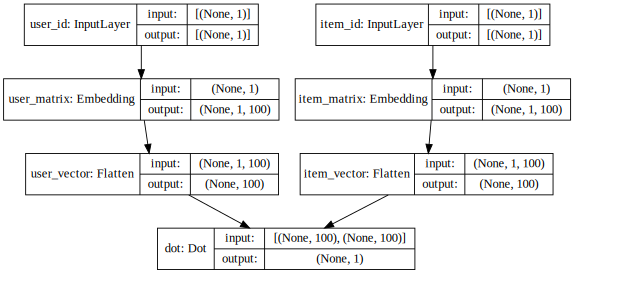

In [18]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, rankdir='HB', dpi=65).create(prog='dot', format='svg'))

We can also use the model.summary() to print a range of model characteristics, such as the number of trainable parameters. 

In [19]:
model.summary()

Model: "shallow_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_matrix (Embedding)         (None, 1, 100)       604100      user_id[0][0]                    
__________________________________________________________________________________________________
item_matrix (Embedding)         (None, 1, 100)       370700      item_id[0][0]                    
______________________________________________________________________________________

- Can you describe how the input data is transformed to the final output? 
- Why do the item_matrix and user_matrix layers return a vector of size (1, 10) each? 
- Why does the user_matrix layer have 604100 parameters? 
- Why does the item_matrix layer have 370700 parameters? 

### Deep latent factor models (gift provided in this tutorial)

In both the lecture and in the first part of this tutorial, we have seen that the rating is predicted by multiplying the two latent vectors. However, recent advances in the field have shown that it is possible to predict the rating by combining the two latent factors (e.g., with a concatenation) and making transformations to the combined vector in cascade with fully-connected layers (deep neural networks). In what follows, we can see an example of how a deep latent factor model can be defined. Please, pay attention to the concatenation and how the cascade of fully-connected layers is defined.

Those who are interested in going into the details of this type of approaches may start by reading a milestone paper iin the field:

- He, X., Liao, L., Zhang, H., Nie, L., Hu, X., & Chua, T. S. (2017). Neural Collaborative Filtering. In: WWW 2017 (pp. 173-182).

In [20]:
def create_deep_model(no_factors, no_users, no_items):
    # User branch
    user_id = tf.keras.layers.Input(shape=[1], name='user_id')
    user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
    user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
    # Item branch
    item_id = tf.keras.layers.Input(shape=[1], name='item_id')
    item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
    item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
    # Concantenation
    vectors_concat = tf.keras.layers.Concatenate()([user_vector, item_vector])
    vectors_concat_dropout = tf.keras.layers.Dropout(0.2)(vectors_concat)
    # Backbone 
    dense_1 = tf.keras.layers.Dense(16,name='fc3')(vectors_concat_dropout)
    dropout_1 = tf.keras.layers.Dropout(0.2,name='d3')(dense_1)
    dense_2 = tf.keras.layers.Dense(8,name='fc4', activation='relu')(dropout_1)
    dense_2_output = tf.keras.layers.Dense(1, activation='relu', name='activation')(dense_2)
    # Model definition
    model = tf.keras.models.Model(inputs=[user_id, item_id], outputs=[dense_2_output], name='deep_model')
    return model

In [21]:
model = create_deep_model(no_factors, no_users, no_items)

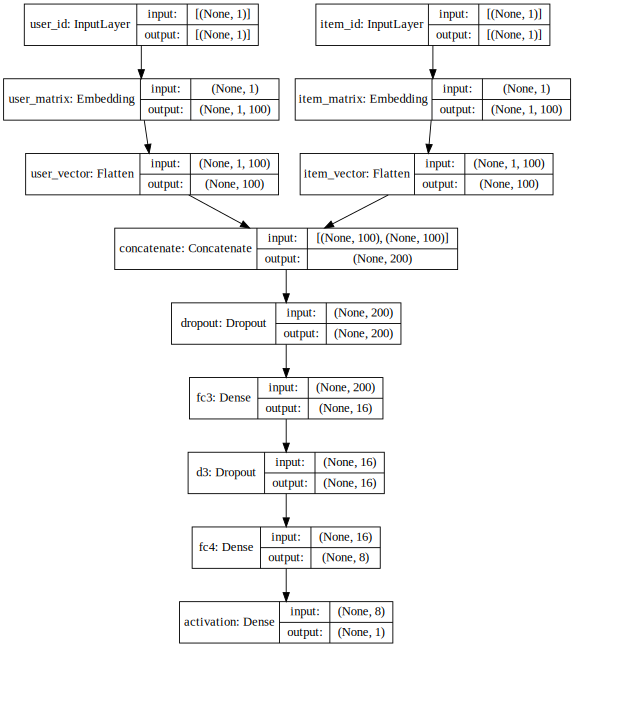

In [22]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, rankdir='HB', dpi=65).create(prog='dot', format='svg'))

By printing the summary, you can get an idea of the number of parameters to learn. 

In [23]:
model.summary()

Model: "deep_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_matrix (Embedding)         (None, 1, 100)       604100      user_id[0][0]                    
__________________________________________________________________________________________________
item_matrix (Embedding)         (None, 1, 100)       370700      item_id[0][0]                    
_________________________________________________________________________________________

- To what extent a deep latent factor model is powerful for this data and context?
- How can we decide on the number and size of the fully-connected layers?

## Step #4: Optimize the latent factor model
---

Once we define the architecture of our latent factor model, we can move on the optimization phase. In this part, we will focus on the shallow latent factor model, but you can easily inspect how the same analysis works for deep latent factor models later in the tutorial or after the tutorial. To start optimizing, we need to define the input data (pairs of user ids and item ids in the training set) and the ourput data (the ground-truth ratings). We initialize the model by capitalizing on the creation function defined previously. Then, we need to tell to the model how it will be optimized. This is done by the compile method. In this case, we adopt mean squared error, leaving experiments with other loss functions as a future work. Finally, we invoke the train method of the model, by passing the train data and labels, the number of epoches (number of times each training sample is seen by the model), and the size of the batches used during optimization. 

In [24]:
# Input-output data definition
X_train = [train_ratings.user_id, train_ratings.item_id]
y_train = train_ratings.rating

# Model creation
model = create_shallow_model(no_factors, no_users, no_items)

# Model compiling 
model.compile(loss=tf.keras.losses.MeanSquaredError())

# Model training
model.fit(X_train, y_train, epochs=10, batch_size=2048, shuffle=True)

Epoch 1/10
392/392 [==============================] - 6s 12ms/step - loss: 13.5527
Epoch 2/10
392/392 [==============================] - 6s 15ms/step - loss: 2.4448
Epoch 3/10
392/392 [==============================] - 5s 13ms/step - loss: 1.0335
Epoch 4/10
392/392 [==============================] - 5s 13ms/step - loss: 0.8840
Epoch 5/10
392/392 [==============================] - 5s 13ms/step - loss: 0.8447
Epoch 6/10
392/392 [==============================] - 5s 12ms/step - loss: 0.8271: 0s - lo
Epoch 7/10
392/392 [==============================] - 5s 12ms/step - loss: 0.8081: 0s 
Epoch 8/10
392/392 [==============================] - 5s 12ms/step - loss: 0.7903: 2s - 
Epoch 9/10
392/392 [==============================] - 5s 12ms/step - loss: 0.7739
Epoch 10/10
392/392 [==============================] - 5s 13ms/step - loss: 0.7578


Once you reach this point, the latent factors are optimized, and you are ready to move to the next step. 

## Step #5: Predict the user-item ratings
---

The next step requires to make predictions on the user-item ratings. Specifically, we are interested in comparing the performance of the model in the training and test set, to assess the extent to which the model performance can generalize on unseen data. To make predictions, we can use the <code>predict</code> method of the model. This method takes pairs of user ids and item ids (similarly to the <code>fit</code> method) and returns the corresponding predicted ratings. 

In [25]:
# Predictions in the training set
X_train = [train_ratings.user_id, train_ratings.item_id]
y_train = train_ratings.rating
y_train_pred = model.predict(X_train, batch_size=2048)

In [26]:
# Predictions in the test set
X_test = [test_ratings.user_id, test_ratings.item_id]
y_test = test_ratings.rating
y_test_pred = model.predict(X_test, batch_size=2048)

In [27]:
y_train_pred, y_test_pred

(array([[3.7901554],
        [3.8163054],
        [4.151822 ],
        ...,
        [4.127607 ],
        [3.9790115],
        [3.7053754]], dtype=float32),
 array([[4.085388 ],
        [3.986267 ],
        [4.7016344],
        ...,
        [3.6738548],
        [2.933577 ],
        [4.390311 ]], dtype=float32))

## Step #6: Evaluate a latent factor model
---

### Prediction accuracy metrics

As seen in the last lecture, prediction accuracy metrics monitor the error rate in rating prediction. To this end, we need datasets with items rated by users (as ml-1m) and the historical user ratings constitute ground truth. The traditional prediction accuracy metrics are MAE Mean Absolute Error, MSE Mean Squared Error, RMSE Root Mean Squared Error (the most-widely used). In this tutorial, we show you how to compure the RMSE for the training and the test set. 

In [28]:
from sklearn.metrics import mean_squared_error
print('Train RMSE:', mean_squared_error(y_train.values, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test.values, y_test_pred, squared=False))

Train RMSE: 0.85574374836874
Test RMSE: 0.9084470639988373


### Decision-support metrics

Decision-support metrics measure how well a recommender helps users make good decisions. Good decisions are about choosing “relevant” items and avoiding “irrelevant” ones. The main decision-support metrics are P Precision and R Recall.

- Precision is a measure of exactness and determines the fraction of relevant items retrieved out of all items retrieved, e.g., the proportion of recommended items actually relevant. Specifically, precision is about returning mostly relevant/useful items, to not waste user time. The assumption is that there is more relevant items than you want. 

- Recall is a measure of completeness and determines the fraction of relevant items retrieved out of all relevant items, e.g., the proportion of all relevant items recommended. Specifically, recall is about not missing relevant items,  i.e., not making a bad oversight. The assumption is that you have time to filter through results to find the items you need. 

Given that this definition covers the entire data set and does not target top-recommended items, it has been introduced the notion of cutoff k: the size of the recommended list. Specifically, Precision@k is the percentage of the top-k items that are “relevant”, and Recall@k is the percentage of the “relevant” items recommended in the top-k items. 

Please, refer to [Lecture 8 slides](https://moodle.epfl.ch/pluginfile.php/2903092/mod_resource/content/10/mlbeh_8_recsys_part2.pdf) for the formulas and the examples. 

Differently from prediction accuracy metrics, decision-support metrics require to compute the list recommended to the user. To this end, for each user, we identify the items already seen in the training phase and those who put apart for the test set. Then, we make the rating predictions for all items for that user, and we force a very low rating for items already seen in the training set (in such a way that they cannot be recommended anymore, the user might not want to get recommended a movie he or she has already seen). Finally, we sort the items based on decreasing predicted rating, and we take the top-k items. Based on this items, we are able to compute the main decision-support metrics, such as precision and recall.   

In [29]:
def predict_from_latent(model, uid, pids, train_ratings=None):
    user_vector = model.get_layer('user_matrix').get_weights()[0][uid]
    item_vectors = model.get_layer('item_matrix').get_weights()[0][pids]
    scores = (np.dot(user_vector, item_vectors.T))
    return scores

In [30]:
def precision_at_k(model, pred_func, train_ratings, test_ratings, no_users, no_items, k=10):
    pid_array = np.arange(no_items, dtype=np.int32)
    precisions = []
    # For each user
    for user_id, user_test_rating in tqdm(test_ratings.groupby('user_id')):
        # Retrieve already-seen items
        train_pids = train_ratings[train_ratings['user_id'] == user_id]['item_id'].values
        # Retrieve the unseen items
        test_pids = set(user_test_rating['item_id'].values)
        # Make rating predictions for all items for that user
        predictions = pred_func(model, user_id, pid_array, train_ratings)
        # Force a low rating to already-seen items
        predictions[train_pids] = - math.inf
        # Sort the items and het the top k
        top_k = set(np.argsort(-predictions)[:k])
        # Compute precision as per definition
        precisions.append(len(top_k & test_pids) / float(k))
    return precisions

In [31]:
precisions = precision_at_k(model, predict_from_latent, train_ratings, test_ratings, no_users, no_items, k=10)

100%|██████████| 6040/6040 [01:11<00:00, 84.38it/s] 


In [32]:
np.mean(precisions), np.std(precisions)

(0.02076158940397351, 0.07177560771163459)

### Exercise #2.1

In the following cell, we ask you to define a function that returns a list with the recalls for all users, individually. Specifically, the signature of the required function should be as follows: 
<code>recall_at_k(model, pred_func, train_ratings, test_ratings, no_users, no_items, k=10)</code>

The returned value is a list of recalls, one per user, as similarly done for precision computation. 

In [33]:
### EXERCISE CELL ###
def recall_at_k(model, pred_func, train_ratings, test_ratings, no_users, no_items, k=10):
    pid_array = np.arange(no_items, dtype=np.int32)
    recalls = []
    for user_id, user_test_rating in tqdm(test_ratings.groupby('user_id')):
        train_pids = train_ratings[train_ratings['user_id'] == user_id]['item_id'].values
        test_pids = set(user_test_rating['item_id'].values)
        predictions = pred_func(model, user_id, pid_array, train_ratings)
        predictions[train_pids] = - math.inf
        top_k = set(np.argsort(-predictions)[:k])
        recalls.append(len(top_k & test_pids) / len(test_pids))
    return recalls

In [34]:
recalls = recall_at_k(model, predict_from_latent, train_ratings, test_ratings, no_users, no_items, k=10)

100%|██████████| 6040/6040 [01:05<00:00, 92.04it/s] 


In [35]:
np.mean(recalls), np.std(recalls)

(0.0048361920053578075, 0.019185999298448674)

### Rank-aware top-k metrics

What we have seen so far (prediction accuracy and decision-support metrics) monitors how accurate the predictions are and how good a recommender system is at finding items. Now, when the recommender list the items, we are interested more in where are the relevant items are placed, and how good the recommender is at predicting relative preference between items. Rank-aware top-k metrics depend on the notion of relevance and take into account the position an item has been recommended. 

### Exercise #2.2
In the following cell, we ask you to define a function that returns a list with the Mean Average Precisions (MAPs) for all users, individually. Specifically, the signature of the required function should be as follows: <code>map_at_k(model, pred_func, train_ratings, test_ratings, no_users, no_items, k=10)</code>. 

The returned value is a list of MAPs, one per user, as similarly done for precision and recall computation.

Please, refer to [Lecture 8 slides](https://moodle.epfl.ch/pluginfile.php/2903092/mod_resource/content/10/mlbeh_8_recsys_part2.pdf) for the formulas and the examples. 

In [36]:
### EXERCISE CELL ###
def map_at_k(model, pred_func, train_ratings, test_ratings, no_users, no_items, k=10):
    pid_array = np.arange(no_items, dtype=np.int32)
    maps = []
    for user_id, user_test_rating in tqdm(test_ratings.groupby('user_id')):
        train_pids = train_ratings[train_ratings['user_id'] == user_id]['item_id'].values
        test_pids = set(user_test_rating['item_id'].values)
        predictions = pred_func(model, user_id, pid_array, train_ratings)
        predictions[train_pids] = - math.inf
        partial_maps = []
        top_k = list(np.argsort(-predictions)[:k])
        for rank, item_id in enumerate(top_k):
            if item_id in test_pids:
                partial_maps.append(len(set(top_k[:rank+1]) & test_pids) / float(rank+1))
        maps.append(.0 if len(partial_maps) == 0 else np.sum(partial_maps) / float(k))
    return maps

In [37]:
maps = map_at_k(model, predict_from_latent, train_ratings, test_ratings, no_users, no_items, k=10)

100%|██████████| 6040/6040 [01:13<00:00, 82.35it/s]


In [38]:
np.mean(maps), np.std(maps)

(0.009218727005150846, 0.048460988543363635)

## Closing exercises

### Exercise #3

1. Train four shallow latent factor models on train_ratings, with 5, 25, 50, and 100 factors, respectively. Other parameters stay as per the previous examples. 
2. Compute the precisions for all users achieved by the four models in test_ratings. 

In [39]:
### EXERCISE CELL ###
X_train = [train_ratings.user_id, train_ratings.item_id]
y_train = train_ratings.rating

metrics = {}
for no_factors in [5, 25, 50, 100]:
    print('Playing with number of factors', no_factors)
    # Create and fit the model
    model = create_shallow_model(no_factors, no_users, no_items)
    model.compile(loss=tf.keras.losses.MeanSquaredError())
    model.fit(X_train, y_train, epochs=10, batch_size=2048, shuffle=True, verbose=0)
    # Compute precision scores
    precisions = precision_at_k(model, predict_from_latent, train_ratings, test_ratings, no_users, no_items, k=10)
    metrics[no_factors] = precisions

Playing with number of factors 5


100%|██████████| 6040/6040 [00:29<00:00, 204.17it/s]


Playing with number of factors 25


100%|██████████| 6040/6040 [00:26<00:00, 225.46it/s]


Playing with number of factors 50


100%|██████████| 6040/6040 [00:40<00:00, 147.73it/s]


Playing with number of factors 100


100%|██████████| 6040/6040 [01:13<00:00, 82.29it/s]


3. Visually report the precisions by means of error bars. 


- What is the impact of the number of factors on the performance?
- Do you have any argument on why these patterns arise?

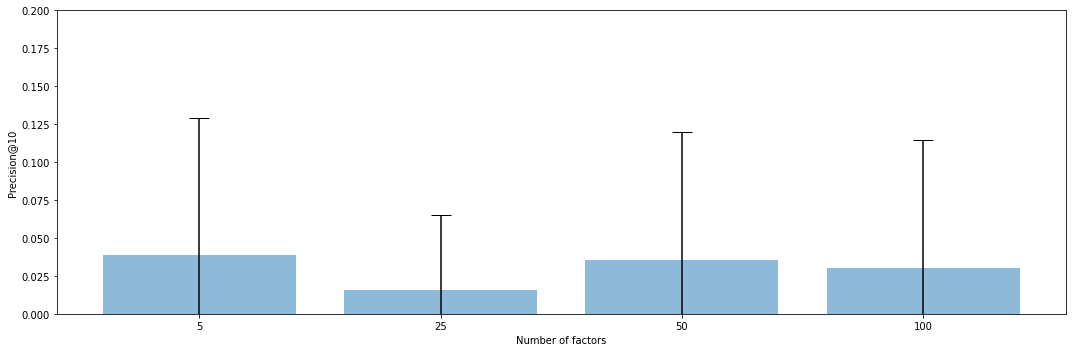

In [40]:
### EXERCISE CELL ###
plt.figure(figsize=(15, 5))

# Compute means, standard deviations, and labels
means, yerrs, labels = [], [], []
for no_factors, model_scores in metrics.items():
    means.append(np.mean(model_scores))
    yerrs.append(np.std(model_scores))
    labels.append(no_factors)

# Plot values
x_pos = np.arange(len(labels))
plt.bar(x_pos, means, yerr=yerrs, align='center', alpha=0.5, ecolor='black', capsize=10)

# Make decorations
plt.xticks(x_pos, labels)
plt.ylabel('Precision@10')
plt.xlabel('Number of factors')
plt.ylim(.0, .2)

plt.tight_layout()
plt.show()

### Exercise #4

In the following cell, we ask you to define a <code>predict_from_pop</code> that returns a numpy array of popularity scores, one per item (i.e., how many ratings that item has received in the data set). Specifically, we ask you to adhere to the following function signature: 

<code>predict_from_pop(model, uid, pids, train_ratings)</code>

This function should return a list of size $|\text{no_items}|$, where the cell at position $i$ represents the popularity of the item $i$ in the training data set.  

In [49]:
### EXERCISE CELL ###
def predict_from_pop(model, uid, pids, train_ratings):
    num_ratings = train_ratings.groupby('item_id')['rating'].count()
    num_ratings.name = 'num_ratings'
    scores = pd.DataFrame(index=pids).merge(num_ratings, left_index=True, right_index=True, how='left').fillna(0)
    return scores['num_ratings'].values

Let's do a quick example of usage to see whether the function works properly. First, we compute the scores for a certain user, e.g., user 1.

In [62]:
scores = predict_from_pop(model, [1], np.arange(no_items), train_ratings)

len(scores)

3706

We sort the popularity scores in decreasing order to retrieve the scaled item ids of the most popular items. For each of them, we print the rank and the original item id (not the scaled one).   

In [63]:
for rank, item_id in enumerate(np.argsort(-scores)[:10]):
    original_item_id = train_ratings[train_ratings['item_id'] == item_id]['original_item_id'].values[0]
    print('#', rank, original_item_id)

# 0 2858
# 1 1196
# 2 260
# 3 1210
# 4 2028
# 5 480
# 6 589
# 7 2571
# 8 1270
# 9 1198


As a double check, let's retrieve the top-10 most popular items directly as done in the previous tutorial. Please, remember that the items dataframe uses the original item ids and not the scaled ones. 

In [58]:
# Create a dataframe with information about the number of received ratings per item
num_ratings = train_ratings.groupby('original_item_id')['rating'].count()
num_ratings.name = 'num_ratings'
num_ratings.head() 

tmp_items = items.copy()
tmp_items = tmp_items.merge(num_ratings, left_on='item_id', right_index=True)

tmp_items.sort_values('num_ratings', ascending=False).head(10)

,item_id,title,genres,num_ratings
2789,2858,American Beauty (1999),Comedy|Drama,3167
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,2742
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,2709
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,2663
1959,2028,Saving Private Ryan (1998),Action|Drama|War,2440
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,2409
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,2389
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,2336
1250,1270,Back to the Future (1985),Comedy|Sci-Fi,2315
1180,1198,Raiders of the Lost Ark (1981),Action|Adventure,2301


The rankings coincide, so the function works as expected. 

### Exercise #5

- Train a shallow latent factor model on train_ratings, in the same way seen in the cells above.  
- Create a grid with two plots, one for precision and one for recall. Each plot should include two error bars: the first one showing the scores achieved by the latent factor model and the second one showing the scores achieved by a recommender that suggests the same most popular items to all users (please use the predict_from_pop function appropriately). 

In [70]:
### EXERCISE CELL ###
X_train = [train_ratings.user_id, train_ratings.item_id]
y_train = train_ratings.rating

model = create_shallow_model(100, no_users, no_items)
model.compile(loss=tf.keras.losses.MeanSquaredError())
model.fit(X_train, y_train, epochs=10, batch_size=2048, shuffle=True, verbose=0)

In [65]:
### EXERCISE CELL ###
metrics = {}
for metr_func, metr_label in zip([precision_at_k, recall_at_k], ['Precision@10', 'Recall@10']):
    metrics[metr_label] = {}
    for pred_func, pred_label in zip([predict_from_latent, predict_from_pop], ['LFM', 'MostPop']):
        metric_scores = metr_func(model, pred_func, train_ratings, test_ratings, no_users, no_items, k=10)
        metrics[metr_label][pred_label] = metric_scores

100%|██████████| 6040/6040 [05:32<00:00, 18.18it/s]


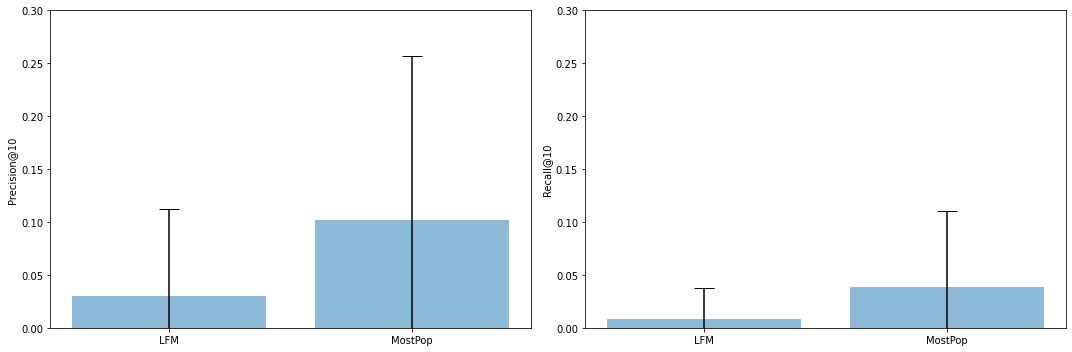

In [67]:
### EXERCISE CELL ###
plt.figure(figsize=(15, 5))

for m_id, metric in enumerate(metrics.keys()):
    
    # Create the subplot for the current metric
    plt.subplot(1, 2, m_id + 1)

    # Compute means, standard deviations, and labels for each model
    means, yerrs, labels = [], [], []
    for model_label, model_scores in metrics[metric].items():
        means.append(np.mean(model_scores))
        yerrs.append(np.std(model_scores))
        labels.append(model_label)
    
    # Plot values
    x_pos = np.arange(len(labels))
    plt.bar(x_pos, means, yerr=yerrs, align='center', alpha=0.5, ecolor='black', capsize=10)
    
    # Make decorations
    plt.xticks(x_pos, labels)
    plt.ylabel(metric)
    plt.ylim(0, .3)

plt.tight_layout()
plt.show()

- What can we conclude from the above plots?
- How can we find tune the latent factor model, to get better performance?

**Hint**. Currently, the latent factor model is optimized for rating prediction, not for providing good rankings (recommended lists to users), which is the main scope of metrics like precision and recall. Therefore, often, the training set used to optimized a latent factor model is often enrighed with "negative examples", i.e., unseen interactions between users and items where the rating is set to 0 (remember that this is just an assumption, given that those interactions are unobserved). You can try to extend the training set with this type of interactions (usually the ratio between observed and unobserved interactions in the training set is around 1:10) and see how the performance in terms of precision and recall changes. 

### Exercise #6

- Create and provide an example usage of a function that, given a user id, prints the top k items (title included) recommended to that user. 

In [71]:
### EXERCISE CELL ###
def show_top_k(model, pred_func, train_ratings, test_ratings, no_users, no_items, items, k=10, user_id=0):
    pid_array = np.arange(no_items, dtype=np.int32)
    
    user_test_rating = test_ratings[test_ratings['user_id'] == user_id]
    
    train_pids = train_ratings[train_ratings['user_id'] == user_id]['item_id'].values
    test_pids = set(user_test_rating['item_id'].values)
    
    predictions = pred_func(model, user_id, pid_array, train_ratings)
    predictions[train_pids] = - math.inf
    top_k = set(np.argsort(-predictions)[:k])
    
    for rank, item_id in enumerate(top_k):
        orig_item = ratings[ratings['item_id'] == item_id]['original_item_id'].values[0]
        item_title = items[items['item_id'] == orig_item]['title'].values[0]
        print('#', rank+1, item_id, item_title)

In [72]:
show_top_k(model, predict_from_latent, train_ratings, test_ratings, no_users, no_items, items, k=10, user_id=2)

# 1 646 Pather Panchali (1955)
# 2 647 Aparajito (1956)
# 3 3080 Circus, The (1928)
# 4 3111 For All Mankind (1989)
# 5 2698 Sanjuro (1962)
# 6 588 Great Day in Harlem, A (1994)
# 7 2158 Nights of Cabiria (Le Notti di Cabiria) (1957)
# 8 208 Before the Rain (Pred dozhdot) (1994)
# 9 628 Cold Fever (Á köldum klaka) (1994)
# 10 2876 Chushingura (1962)


## Further steps
---

- Repeat the analysis on another dataset. 
- Repeat on another evaluation methods (e.g., cross validation) and splitting strategies (e.g., fixed time stamp for all). 
- Repeat on another latent factor models, more advanced in terms of architecture. 
- Compare your model with traditional models manipulated by Surprise and seen in the previous lecture.
- ...

## Summary
---

In this tutorial, we introduced latent factor models, from their definition to their evaluation. Furthermore, we presented several evaluation methods and performance metrics, that are important for assessing the impact of the solution on the real world.